## MC38 Spheroid Viability Quantification

This notebook will analyze MC38 spheroid images containing a bright-field channel and two fluorescent channels with dyes to identify live and dead cells.  These images were taken under 3 conditions: 

1. **Control**: In this condition, cells were cultured with no treatment
2. **1% DMSO**: Slight DMSO treatment intended to kill cells with limited efficiency
3. **10% DMSO**: DMSO treatment intended to kill nearly all cells

The output of this analysis includes 2 primary objectives:

- The viability of cells in each spheroid (for each condition)
- Stitched images of all tiles filtered to valid spheroid objects

Note that this last objective requires selecting objects based on results from the Cytokit pipeline and then projecting those choices onto stitched experiment images.  In other words, the pipeline produces a data frame with properties for each object (cell usually, but not in this case) in each row and this notebook will select the desirable objects based on those properties and visualize those selections by matching them to objects in images.

Additionally, as this dataset concerns spheroids rather than cells, a [custom segmentation algorithm](spheroid_cytometer.py) was applied to generate the per-object data analyzed here. 

In [1]:
%matplotlib inline
import os
import tqdm
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
import plotnine as pn
from cytokit import io as ck_io
from cytokit import config as ck_config
from cytokit.function import data as ck_data
from cytokit.image import proc as ck_img_proc

### Loading

Define a set of experiment conditions for which all operations will be repeated:

In [2]:
# Pull a set of directory -> condition mappings
df_exp = pd.read_csv('experiments.csv')
df_exp

name   dir condition
0  20190215-mc38-dmso-control  XY02  DMSO-10p
1  20190215-mc38-dmso-control  XY03  DMSO-01p
2  20190215-mc38-dmso-control  XY07  DMSO-00p

Load the segmented object data for each experiment and restrict each object to only the z plane for which the cross-section size is largest.  In this case, this is analgous to finding the slice in best focus, per-object, since it amounts to finding the slice with the largest amount of high-frequency information:

In [3]:
def output_dir(name, directory):
    return osp.join(os.environ['CYTOKIT_DATA_DIR'], 'cytokit', 'mc38-spheroid', name, directory, 'output', 'v00')

def get_data(exp_name, exp_dir):
    out_dir = output_dir(exp_name, exp_dir)    
    conf_dir = osp.join(out_dir, 'config')
    config = ck_config.load(conf_dir)
    df = ck_data.get_cytometry_data(out_dir, config, mode='all')
    
    # Group by cell and return z slice for largest cross section
    df = df.groupby(['region_index', 'tile_index', 'id'], group_keys=False).apply(lambda g: g.sort_values('cm:size').tail(1))
    
    df['exp_dir'] = exp_dir
    df['out_dir'] = out_dir
    df['conf_dir'] = conf_dir
    
    return df
    
df = pd.concat([
    get_data(r['name'], r['dir']).assign(name=r['name'], condition=r['condition'])
    for i, r in df_exp.iterrows()
])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 11 to 65
Data columns (total 80 columns):
region_index                         143 non-null int64
tile_index                           143 non-null int64
tile_x                               143 non-null int64
tile_y                               143 non-null int64
rid                                  143 non-null int64
rx                                   143 non-null float64
ry                                   143 non-null float64
id                                   143 non-null int64
x                                    143 non-null float64
y                                    143 non-null float64
z                                    143 non-null int64
cm:size                              143 non-null float64
cm:size_vx                           143 non-null int64
cm:diameter                          143 non-null float64
cm:diameter_vx                       143 non-null float64
cm:perimeter                         143 

In [4]:
# Ensure that there is a record for only one z plane for each cell
assert df.groupby(['name', 'condition', 'tile_index', 'id'])['z'].nunique().max() == 1

### Gating

Filter objects to remove those far less likely to be valid spheroids:

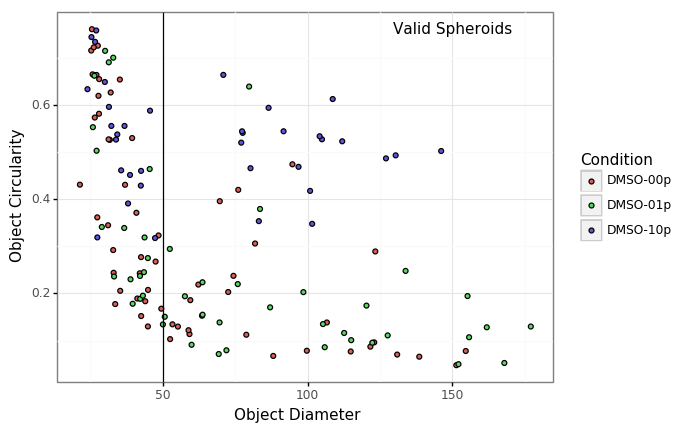

<ggplot: (-9223363297433835106)>

In [9]:
xv, yv = 'cm:diameter', 'cm:circularity'
xt = 50

# Show gate on diameter 
(
    pn.ggplot(df, pn.aes(x=xv, y=yv, fill='condition')) +
    pn.geom_point() + 
    pn.geom_vline(xintercept=xt) + 
    pn.annotate('text', x=150, y=df[yv].max(), label='Valid Spheroids') +
    pn.theme_bw() + 
    pn.labs(x='Object Diameter', y='Object Circularity', fill='Condition')
)

In [11]:
# Get objects passing size filter
dff = df[(df[xv] >= xt)][[
    'id', 'region_index', 'tile_index', 'tile_x', 'tile_y', 'z',
    'exp_dir', 'out_dir', 'conf_dir', 'name', 'condition', 
    'cm:diameter', 'cm:BF:lbp:mean', 'ci:LIVE:mean', 'ci:DEAD:mean'
]]
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 11 to 64
Data columns (total 15 columns):
id                73 non-null int64
region_index      73 non-null int64
tile_index        73 non-null int64
tile_x            73 non-null int64
tile_y            73 non-null int64
z                 73 non-null int64
exp_dir           73 non-null object
out_dir           73 non-null object
conf_dir          73 non-null object
name              73 non-null object
condition         73 non-null object
cm:diameter       73 non-null float64
cm:BF:lbp:mean    73 non-null float64
ci:LIVE:mean      73 non-null float64
ci:DEAD:mean      73 non-null float64
dtypes: float64(4), int64(6), object(5)
memory usage: 9.1+ KB


### Visualize Individual Spheroid Images

Attach images of each individual spheroid at the appropriate z depth:

In [12]:
# Configure display settings for individual spheroid images
ranges = {
    'proc_BF': [0, np.inf],
    'proc_LIVE': [0, np.inf],
    'proc_DEAD': [0, np.inf],
    'cyto_cell_boundary': [0, 1]
}
colors = {
    'proc_BF': 'gray',
    'proc_LIVE': 'green',
    'proc_DEAD': 'red',
    'cyto_cell_boundary': 'cyan'
}
    
def add_cell_images(g):
    assert g['out_dir'].nunique() == 1
    return ck_data.get_single_cell_image_data(
        g['out_dir'].iloc[0], g, 'segm', ranges=ranges, colors=colors, 
        image_size=(512, 512), apply_mask=False, z=None, fill_value=255
    )

dfp = dff.groupby(['name', 'condition'], group_keys=False).apply(add_cell_images)
dfp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 0 to 17
Data columns (total 17 columns):
id                73 non-null int64
region_index      73 non-null int64
tile_index        73 non-null int64
tile_x            73 non-null int64
tile_y            73 non-null int64
z                 73 non-null int64
exp_dir           73 non-null object
out_dir           73 non-null object
conf_dir          73 non-null object
name              73 non-null object
condition         73 non-null object
cm:diameter       73 non-null float64
cm:BF:lbp:mean    73 non-null float64
ci:LIVE:mean      73 non-null float64
ci:DEAD:mean      73 non-null float64
image             73 non-null object
properties        73 non-null object
dtypes: float64(4), int64(6), object(7)
memory usage: 10.3+ KB


In [13]:
# Show number of spheroids by condition
dfp['condition'].value_counts()

DMSO-01p    29
DMSO-00p    26
DMSO-10p    18
Name: condition, dtype: int64

Show all valid spheroids for each condition:

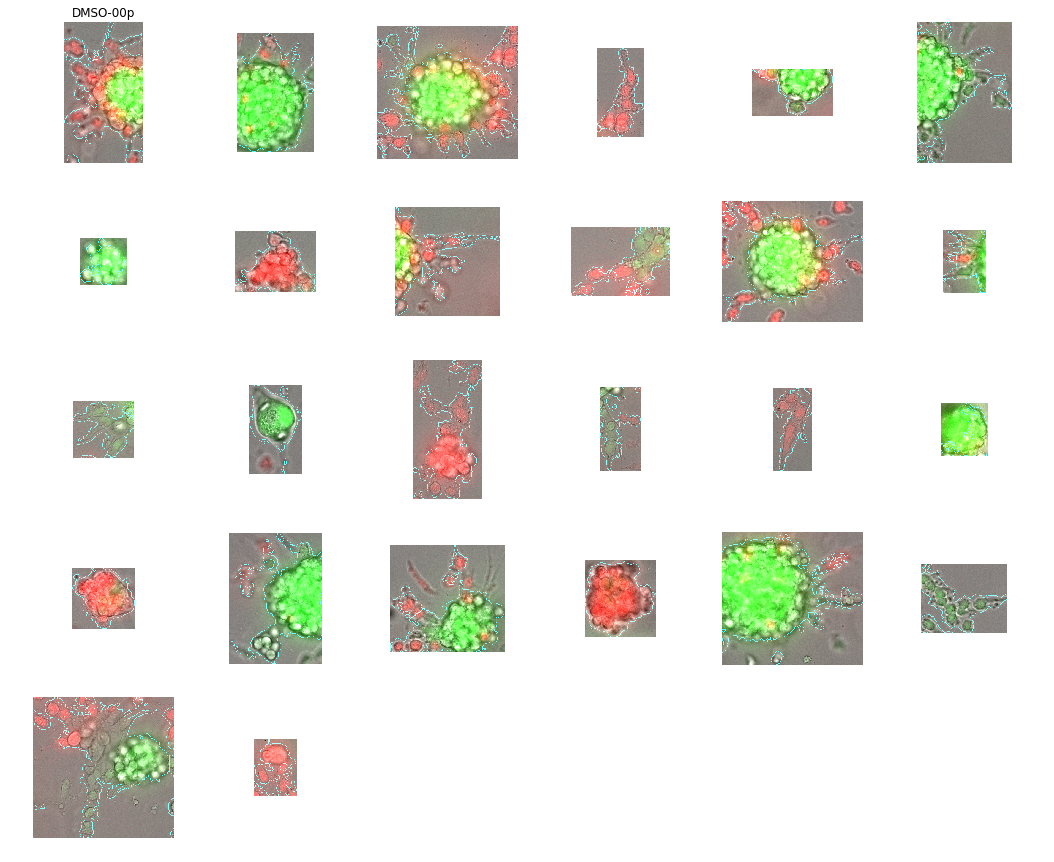

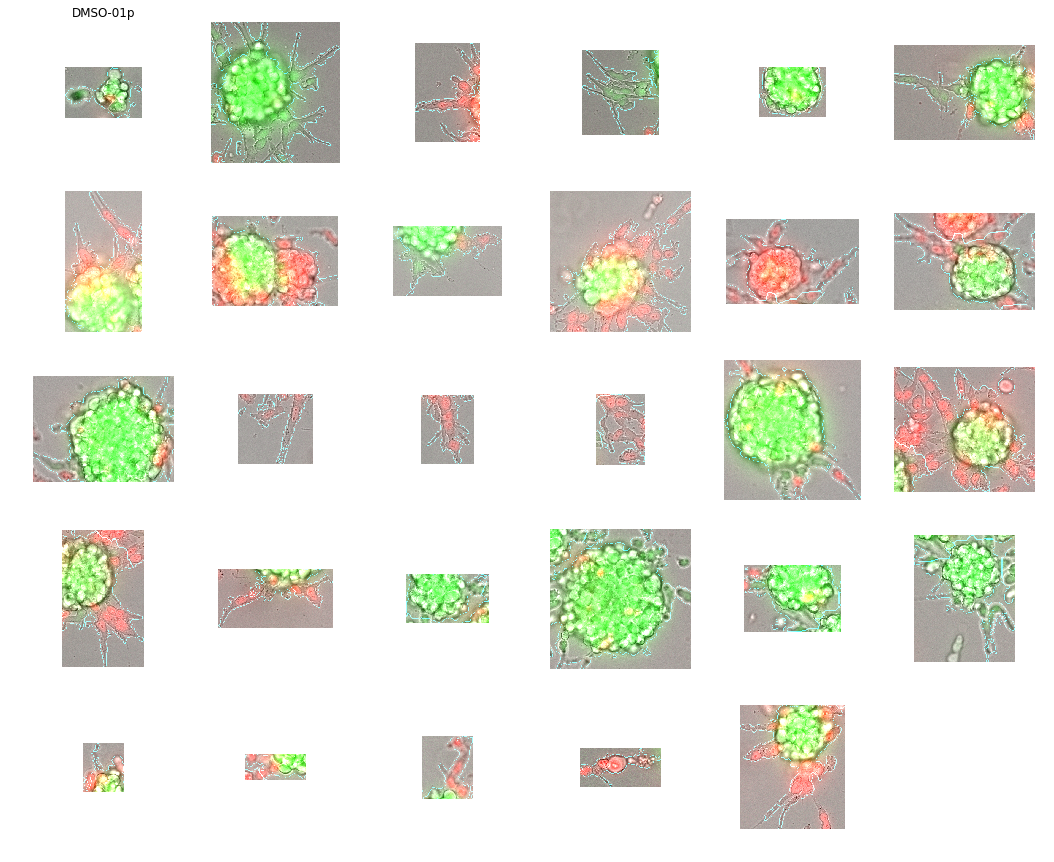

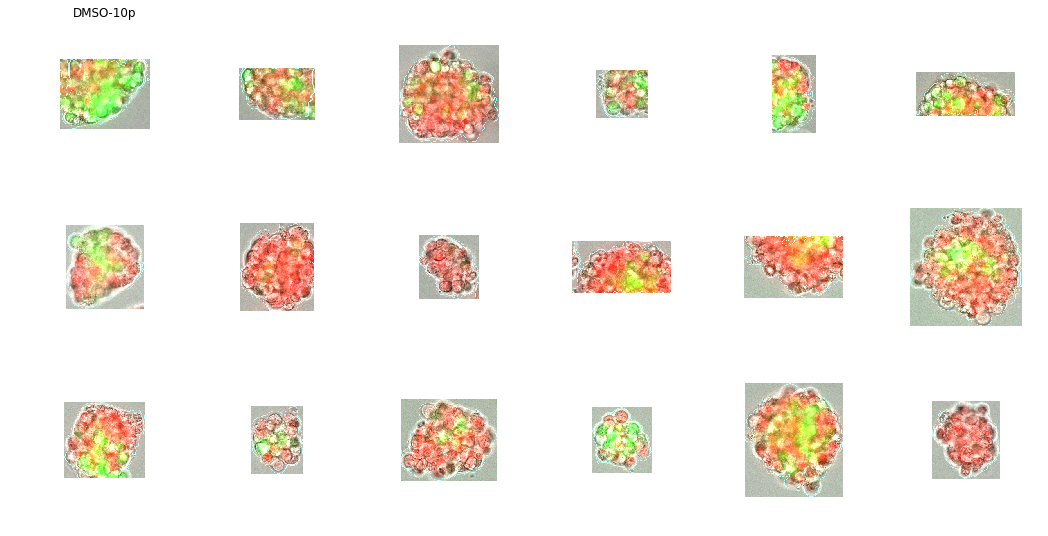

In [16]:
# Render individual spheroids under each condition
for k, g in dfp.groupby('condition'):
    images = g['image']
    cols = 6
    n = len(images)
    rows = int(np.ceil(n / cols))
    fig, axs = plt.subplots(rows, cols)
    axs = axs.ravel()
    for ax in axs:
        ax.axis('off')
    fig.set_size_inches(cols*3, rows*3)
    axs[0].set_title(k)
    for i, img in enumerate(images):
        axs[i].axis('off')
        axs[i].imshow(img)

Show spheroid viability distribution for each condition (At TOW, untreated and 1% DMSO groups were nearly identical while spheroids in 10% DMSO group were comprised nearly entirely of dead cells):

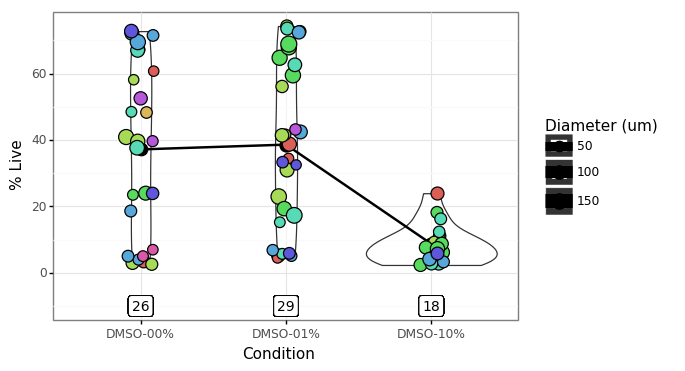

<ggplot: (-9223363297435624609)>

In [17]:
# Determine average cell viability within each spheroid by dividing total live intensity by live intensity + dead intensity
dfplt = (
    dfp
    .assign(pct=lambda df: 100 * df['ci:LIVE:mean'] / (df['ci:LIVE:mean'] + df['ci:DEAD:mean']))
    .assign(condition=lambda df: df['condition'].str.replace('p$', '%'))
    .assign(condition=lambda df: pd.Categorical(df['condition'], categories=sorted(df['condition'].unique()), ordered=True))
    .assign(id=lambda df: df['id'].astype(str))
    .assign(text=lambda df: df['condition'].map(df.groupby('condition').size()))
)
(
    pn.ggplot(dfplt, pn.aes(x='condition', y='pct', size='cm:diameter')) + 
    pn.geom_violin(alpha=.5) + 
    pn.geom_point(data=dfplt.groupby('condition')[['pct', 'cm:diameter']].mean().reset_index(), color='black', shape='o') + 
    pn.geom_line(
        mapping=pn.aes(x='condition', y='pct', group=1, size=1), 
        data=dfplt.groupby('condition')[['pct', 'cm:diameter']].mean().reset_index(), color='black'
    ) + 
    pn.geom_jitter(pn.aes(fill='id'), width=.1) + 
    pn.geom_label(pn.aes(label='text', y=-10), size=10) +
    pn.labs(x='Condition', y='% Live', fill='Spheroid ID', size='Diameter (um)') +
    pn.scale_fill_discrete(guide=False) + 
    pn.theme_bw() + 
    pn.theme(figure_size=(6, 4))
    
)

### Visualize Montage

Show montage images (of all tiles) for each condition with valid spheroids highlighted:

In [18]:
from cytokit.image import ops as image_ops
from cytokit.image import proc as image_proc
from skimage import morphology

def get_montage(out_dir, df, config, grid_size=3, boundary_size=10):
    path = osp.join(out_dir, 'montage', 'bestz_segm', 'R001.tif')
    img, meta = ck_io.read_tile(path, return_metadata=True)
    imgs = img[0, 0, [meta['labels'].index(c) for c in ['proc_BF', 'proc_LIVE', 'proc_DEAD', 'cyto_cell_boundary']]]
    
    # Restrict object label image to object ids matching data frame (and dilate boundary to make larger for visualization)
    imgs[-1] = image_ops.filter_label_image(imgs[-1], df, config)
    imgs[-1] = morphology.dilation(imgs[-1] > 0, selem=morphology.disk(boundary_size)) * np.iinfo(img.dtype).max       
    
    # Merge multi-channel image into single RGB
    img = image_proc.get_image_processor(
        # Note that these channel names must match order of imgs above
        ['BF', 'LIVE', 'DEAD', 'OBJ'], 
        ranges={'OBJ': [0, 1], 'BF': [np.iinfo(img.dtype).max*.5, None]},
        colors={'BF': 'gray', 'LIVE': 'green', 'DEAD': 'red', 'OBJ': 'blue'}
    ).run(imgs)
    
    # Draw grid lines at imaging tile borders
    if grid_size:
        img_grid = np.zeros(img.shape[:2], dtype='bool')
        for ri in range(config.region_height):
            img_grid[ri*config.tile_height, :] = True
        for ci in range(config.region_width):
            img_grid[:, ci*config.tile_width] = True
        img_grid = morphology.binary_dilation(img_grid, selem=morphology.disk(grid_size))
        img[img_grid > 0] = 0

    return img


imgs = {}
for k, g in dfp.groupby('condition'):
    out_dir = g['out_dir'].iloc[0]
    config = ck_config.load(g['conf_dir'].iloc[0])
    imgs[k] = get_montage(out_dir, g, config, grid_size=3)

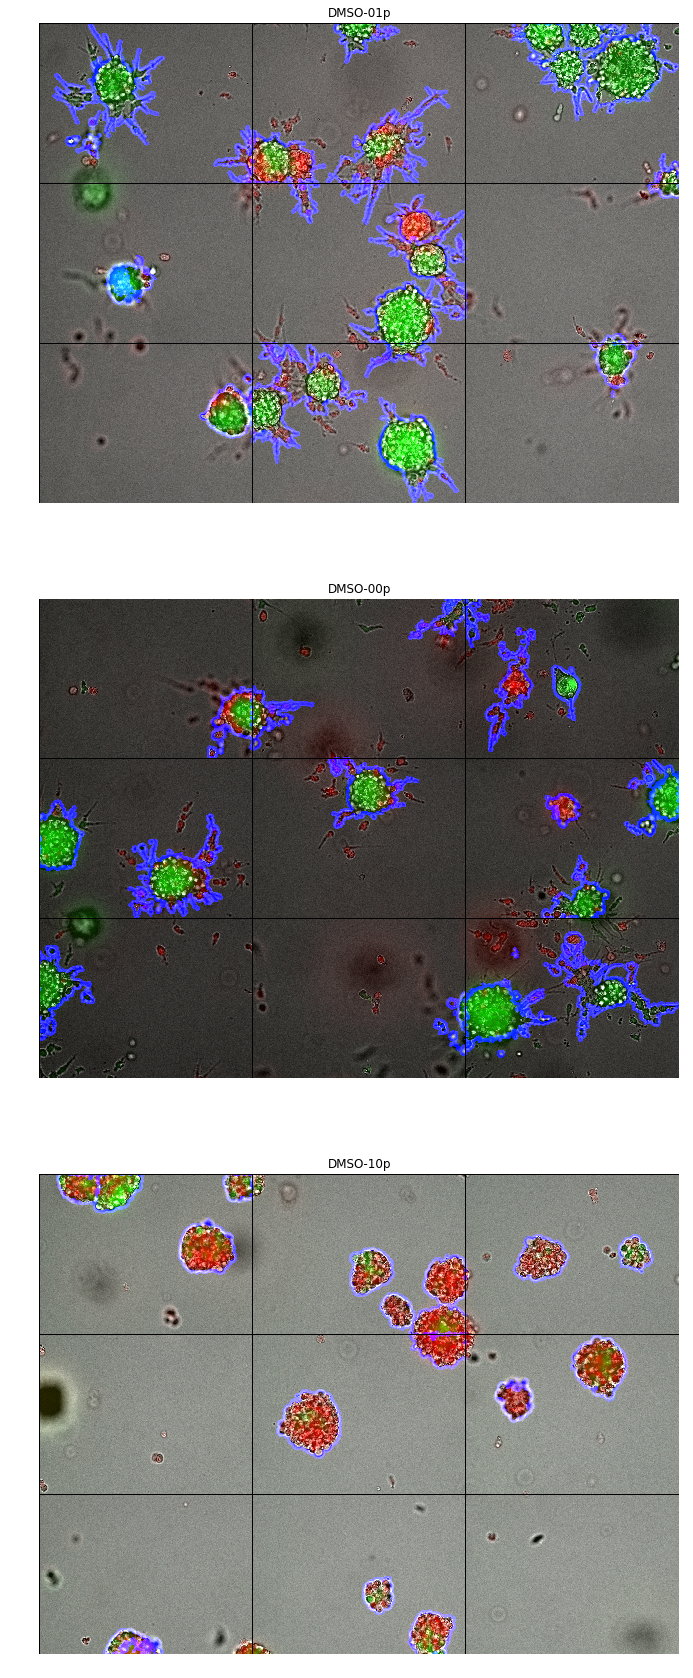

In [19]:
fig, ax = plt.subplots(len(imgs), 1)
fig.set_size_inches(24*len(imgs), 30)
for i, (k, img) in enumerate(imgs.items()):
    ax[i].set_title(k)
    ax[i].imshow(img)
    ax[i].axis('off')